---
# Imports

In [1]:
import random

import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler



from utils.data_utils import scale_data_per_country
from utils.model_utils import StackedLSTM, init_weights, StackedRNN

In [2]:
def get_pd_from_pkl(path: str) -> pd.DataFrame:
    df = pd.read_pickle(path)
    return df
# df = get_pd_from_pkl(path=r"data\training_data\training_added_feats_no_hospital.pkl")
# df = get_pd_from_pkl(path=r"data\training_data\training_data_v1.0.pkl")
df_og = get_pd_from_pkl(path="data/training_data/training_datav2_0-weekly.pkl")
# df_policies = get_pd_from_pkl(path=r"data\all_policies\policies_individual_final.pkl")
# df_vaccines = get_pd_from_pkl(path=r"data\timeseries_pickles\additional_features\better_vaccine_data.pkl")
df = df_og.copy()

In [3]:
#MERGE DATAFRAMES

# df_vaccines_policies = pd.merge(left=df_vaccines, right=df_policies, how="inner", 
#                                 on=["location", "date"])
# df_vaccines_policies = df_vaccines_policies.sort_values(by=["location", "date"])
# df_og = df_og.sort_values(by=["location", "date"])
# df_vaccines_policies['new_cases'] = df_og['new_cases']
# df = df_vaccines_policies.copy()

In [4]:
# # Load the pickle file
# file_path = "data/training_data/training_datav2_0-weekly.pkl"
# df = pd.read_pickle(file_path)

# # Display the first few rows of the DataFrame
# df.head()

---
# Prepare data

In [5]:
# def get_all_but_one_data(target_country: str, df: pd.DataFrame, feature_columns: list, target_column: str):
    
#     full_data = df.dropna().copy()
#     full_data = full_data[['location', 'C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']]
#     full_data.loc[:, 'target'] = full_data['weekly_cases']
    
#     train_data = full_data[full_data['location'] != target_country].copy()
#     test_data = full_data[full_data['location'] == target_country].copy()
    
#     y_train, X_train = scale_data_per_country(
#                                         df=train_data, feature_columns=feature_columns,
#                                         countries=list(train_data['location'].unique()),
#                                         target_column=target_column, scaler=MinMaxScaler()
#                                         )
#     y_test, X_test = scale_data_per_country(
#                                         df=test_data, feature_columns=feature_columns,
#                                         countries=list(test_data['location'].unique()),
#                                         target_column=target_column, scaler=MinMaxScaler(),
#                                         seq_length=4
#                                         )
    
#     return X_train, y_train, X_test, y_test
    

In [6]:
def get_data_laoders(X_train, y_train, X_test, y_test, device, batch_size = 32):
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

    # Create DataLoader
    batch_size = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [7]:
# original_columns = ['location', 'date', 'weekly_cases', 'C', 'E', 'G', 'S',
#        'biweekly_cases', 'biweekly_deaths', 'new_cases', 'new_deaths',
#        'total_cases', 'total_deaths', 'weekly_deaths',
#        'daily_vaccinations_per_million', 'total_vaccinations_per_hundred',
#        'Weekly new ICU admissions', 'Weekly new ICU admissions per million',
#        'Weekly new hospital admissions',
#        'Weekly new hospital admissions per million']

# used_columns = ['location', 'date', 'weekly_cases', 'C', 'E', 'G', 'S']
       # 'total_vaccinations_per_hundred', 'daily_vaccinations_per_million']

# extra_not_use_columns = list(set(original_columns) - set(used_columns))

In [8]:
feature_columns = ['new_cases']
# info_columns = ['location', 'date']
# used_columns = feature_columns + info_columns


#especific per quan fem servir les dades de policies disgregagades
# feature_columns = ['total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
#        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
#        'c1m', 'c2m', 'c3m', 'c4m', 'c5m', 'c6m', 'c7m',
#        'c8ev', 'e1', 'e2', 'h1', 'h2', 'h3', 'h6m', 'h7', 'h8m', 'new_cases']
info_columns = ['location', 'date']

used_columns = feature_columns + info_columns
used_columns

['new_cases', 'location', 'date']

In [9]:
full_data = df[used_columns].fillna(0).copy()
# full_data = full_data[['location', 'C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']]
#per afegir noves features
# full_data = full_data[features]
full_data.loc[:, 'target'] = full_data['new_cases']

# Filter out locations that appear less than 20 times
location_counts = full_data['location'].value_counts()
valid_locations = location_counts[location_counts >= 20].index
full_data = full_data[full_data['location'].isin(valid_locations)]

In [10]:
#TREURE LES NEW_CASES
# full_data = full_data.drop(columns=['new_cases'])
# feature_columns.remove('new_cases')
# feature_columns

In [11]:
random.seed(42)  # Set the random seed for reproducibility
target_country = random.sample(list(full_data.location.unique()), 8)
target_country = ['Spain']
target_country

['Spain']

In [12]:
train_data = full_data[~full_data['location'].isin(target_country)].copy()
# train_data = train_data.loc[~train_data['location'].isin(['luxembourg', 'cyprus'])]
test_data = full_data[full_data['location'].isin(target_country)].copy()
# test_data = test_data.loc[~test_data['location'].isin(['luxembourg', 'cyprus'])]

In [13]:
# test_data.loc[:, ['C', 'E', 'G', 'S', 'daily_vaccinations_per_million']] = 0

In [14]:
# feature_columns = ['C', 'E', 'G', 'S', 'weekly_deaths', 'weekly_cases']
feature_columns = feature_columns
target_column = "target"

#Get Train data

#Initialize scaler
scaler_X_train = MinMaxScaler()
scaler_y_train = MinMaxScaler()
y_train, X_train = scale_data_per_country(
                                    df=train_data, feature_columns=feature_columns,
                                    countries=list(train_data['location'].unique()),
                                    target_column=target_column, scaler=MinMaxScaler()
                                    )

#Get Test data
scaler_X_test = MinMaxScaler()
scaler_y_test = MinMaxScaler()
y_test, X_test = scale_data_per_country(
                                    df=test_data, feature_columns=feature_columns,
                                    countries=list(test_data['location'].unique()),
                                    target_column=target_column, scaler=MinMaxScaler(),
                                    seq_length=4
                                    )


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

---
# Training

## Training utils

In [17]:
def init_model(input_size:int, hidden_size:int, num_layers:int, output_size:int) -> nn.Module:
    """Instantiates the model and initializes weights.
    The model is a stacked LSTM with the specified input size, 
    hidden size, number of layers, and output size.

    Args:
        input_size (int): Input size to the LSTM layer.
        hidden_size (int): Hidden size of the LSTM layer.
        num_layers (int): Number of LSTM layers.
        output_size (int): Output size of the model.

    Returns:
        nn.Module: The initialized model.
    """
    model = StackedLSTM(input_size, hidden_size, num_layers, output_size)
    # model = StackedRNN(input_size, hidden_size, num_layers, output_size)
    model.apply(init_weights)
    return model.to(device)

## Training exec

In [18]:
#PARAMS PER LSTM
# input_size= X_train.shape[2]
# hidden_size=64
# num_layers= 2
# output_size=1
# learning_rate=0.001
# weight_decay = 1e-4

# model = init_model(input_size, hidden_size, num_layers, output_size)

In [18]:
#PARAMS PER RNN
input_size = X_train.shape[2]
hidden_size = 64       # ⬆️ Augmentem una mica per compensar la menor capacitat que el LSTM
num_layers = 2
output_size = 1
learning_rate = 0.001
weight_decay = 1e-4
model = init_model(input_size, hidden_size, num_layers, output_size)


# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize training parameters
num_epochs = 100 # Adjust as needed
print_every = 10  # Set how often to print

# Store losses
train_losses = []
val_losses = []  # This will now store RMSE on test set per epoch

# Start training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # Only keep predictions and inputs from the last epoch
    if epoch == num_epochs - 1:
        predictions_last = []
        actuals_last = []
        inputs_last = []

    # Training loop
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if epoch == num_epochs - 1:
            predictions_last.extend(y_pred.cpu().detach().numpy())
            actuals_last.extend(y_batch.cpu().numpy())
            inputs_last.extend(X_batch.cpu().numpy())

    # Compute average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- RMSE Validation loop on test set ---
    model.eval()
    test_predictions = []
    test_actuals = []

    with torch.no_grad():
        for i in range(len(X_test_tensor)):
            X_val = X_test_tensor[i].unsqueeze(0).to(device)
            y_val = y_test_tensor[i].unsqueeze(0).to(device)

            y_pred = model(X_val)
            test_predictions.append(y_pred.cpu().numpy().flatten()[0])
            test_actuals.append(y_val.cpu().numpy().flatten()[0])

    # Compute RMSE as validation loss
    rmse_val = np.sqrt(mean_squared_error(test_actuals, test_predictions))
    val_losses.append(rmse_val)

    # Print losses
    if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, RMSE (Test): {rmse_val:.4f}")


Epoch [10/100] - Train Loss: 0.0027, RMSE (Test): 0.0347
Epoch [20/100] - Train Loss: 0.0026, RMSE (Test): 0.0320
Epoch [30/100] - Train Loss: 0.0025, RMSE (Test): 0.0312
Epoch [40/100] - Train Loss: 0.0024, RMSE (Test): 0.0310
Epoch [50/100] - Train Loss: 0.0024, RMSE (Test): 0.0310
Epoch [60/100] - Train Loss: 0.0023, RMSE (Test): 0.0312
Epoch [70/100] - Train Loss: 0.0023, RMSE (Test): 0.0313
Epoch [80/100] - Train Loss: 0.0023, RMSE (Test): 0.0312
Epoch [90/100] - Train Loss: 0.0023, RMSE (Test): 0.0311
Epoch [100/100] - Train Loss: 0.0023, RMSE (Test): 0.0311


In [20]:
model.eval()
train_predictions = []
train_actuals = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)
        train_predictions.append(y_pred.cpu())
        train_actuals.append(y_batch.cpu())

# Convert to tensors or numpy
train_predictions = torch.cat(train_predictions).numpy()
train_actuals = torch.cat(train_actuals).numpy()


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# Convert to numpy arrays
preds = np.array(test_predictions)
actuals = np.array(test_actuals)

# Compute metrics
mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
r2 = r2_score(actuals, preds)

print(f"\nTest Country Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Save metrics
test_country = target_country  # or whatever test country you're working with
metrics = {
    "country": test_country,
    "mae": mae,
    "rmse": rmse,
    "r2": r2
}

# os.makedirs("results", exist_ok=True)
# with open(f"results/metrics_{test_country}.json", "w") as f:
#     json.dump(metrics, f, indent=4)



Test Country Metrics:
MAE: 0.0152
RMSE: 0.0311
R2 Score: 0.9624


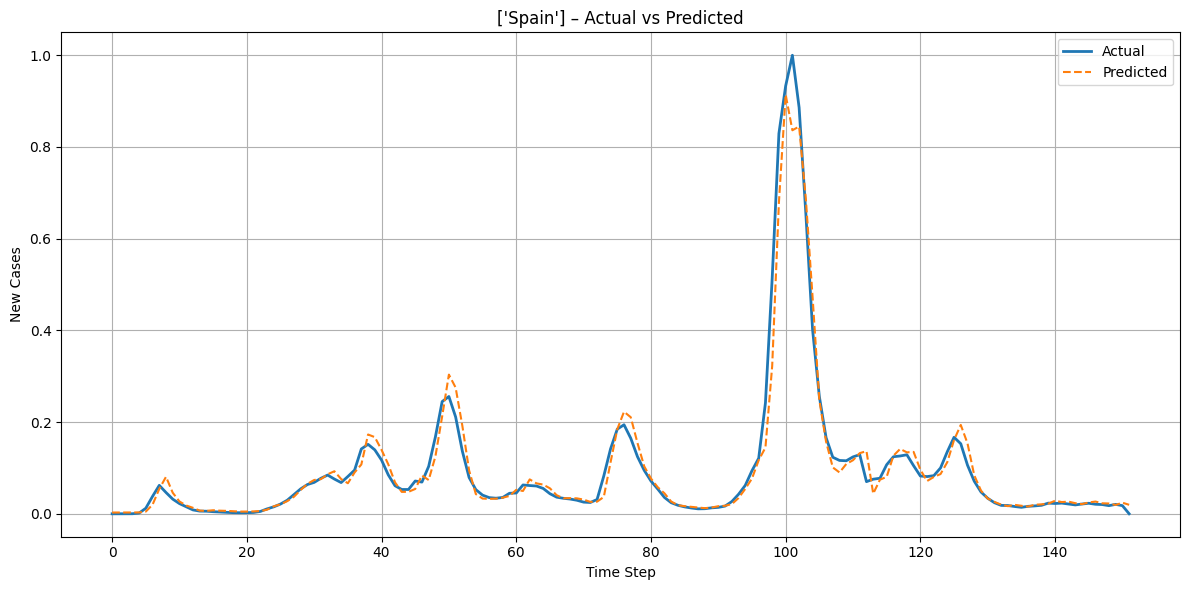

In [22]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', linewidth=2)
plt.plot(preds, label='Predicted', linestyle='--')
plt.title(f"{test_country} – Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/prediction_plot_{test_country}.png")
plt.show()

## punt

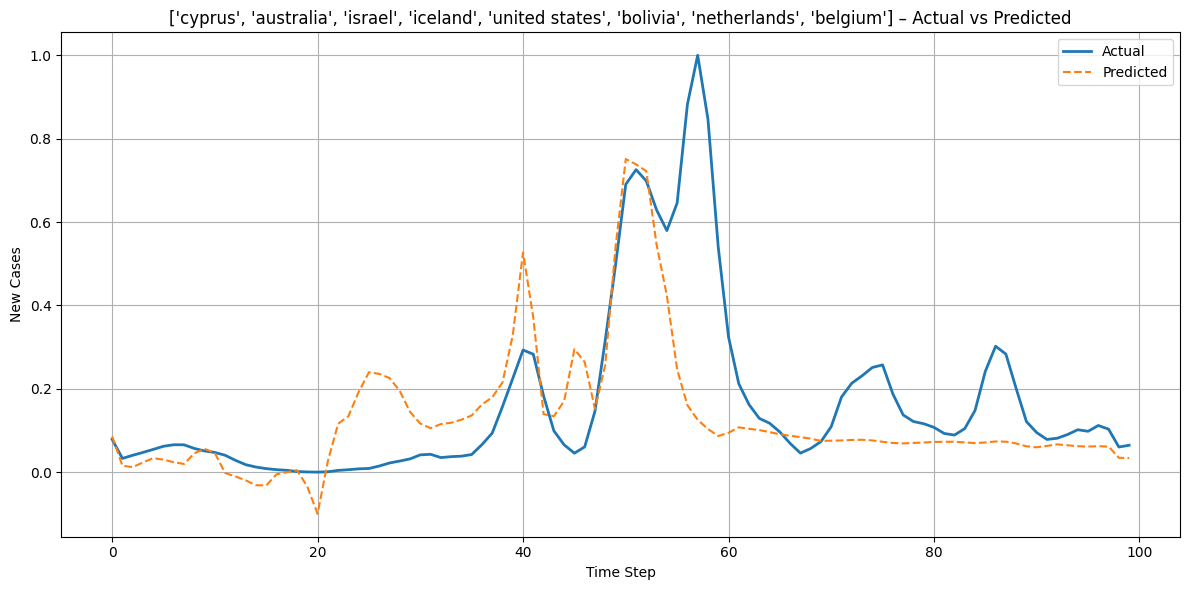

In [26]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(train_actuals[100:200], label='Actual', linewidth=2)
plt.plot(train_predictions[100:200], label='Predicted', linestyle='--')
plt.title(f"{test_country} – Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/prediction_plot_{test_country}.png")
plt.show()

In [24]:
# Plot actual vs predicted
df_target = df.loc[df.location == target_country].copy().reset_index(drop=True)
plt.figure(figsize=(12, 6))


plt.plot(df_target['Weekly new ICU admissions per million'], label='Weekly new ICU admissions per million', linewidth=2)
plt.plot(df_target['Weekly new hospital admissions per million'], label='Weekly new hospital admissions per million', linewidth=2)
plt.title(f"{test_country} – Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/prediction_plot_{test_country}.png")
plt.show()

ValueError: ('Lengths must match to compare', (2484,), (8,))

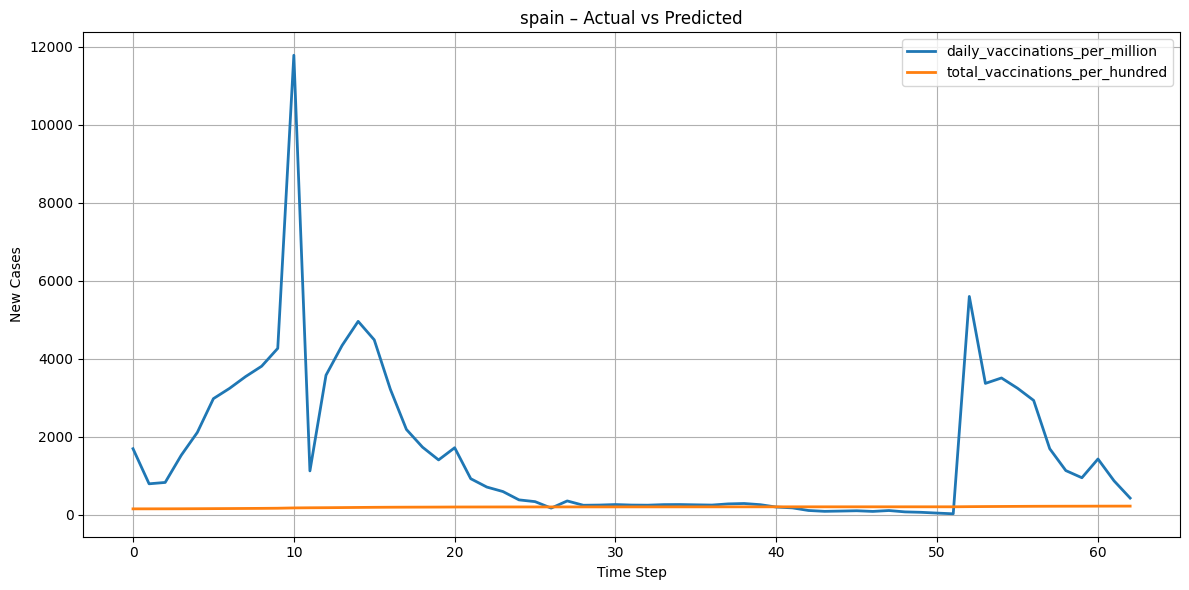

In [ ]:
# Plot actual vs predicted
df_target = df.loc[df.location == target_country].copy().reset_index(drop=True)
plt.figure(figsize=(12, 6))


plt.plot(df_target['daily_vaccinations_per_million'], label='daily_vaccinations_per_million', linewidth=2)
plt.plot(df_target['total_vaccinations_per_hundred'], label='total_vaccinations_per_hundred', linewidth=2)
plt.title(f"{test_country} – Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/prediction_plot_{test_country}.png")
plt.show()

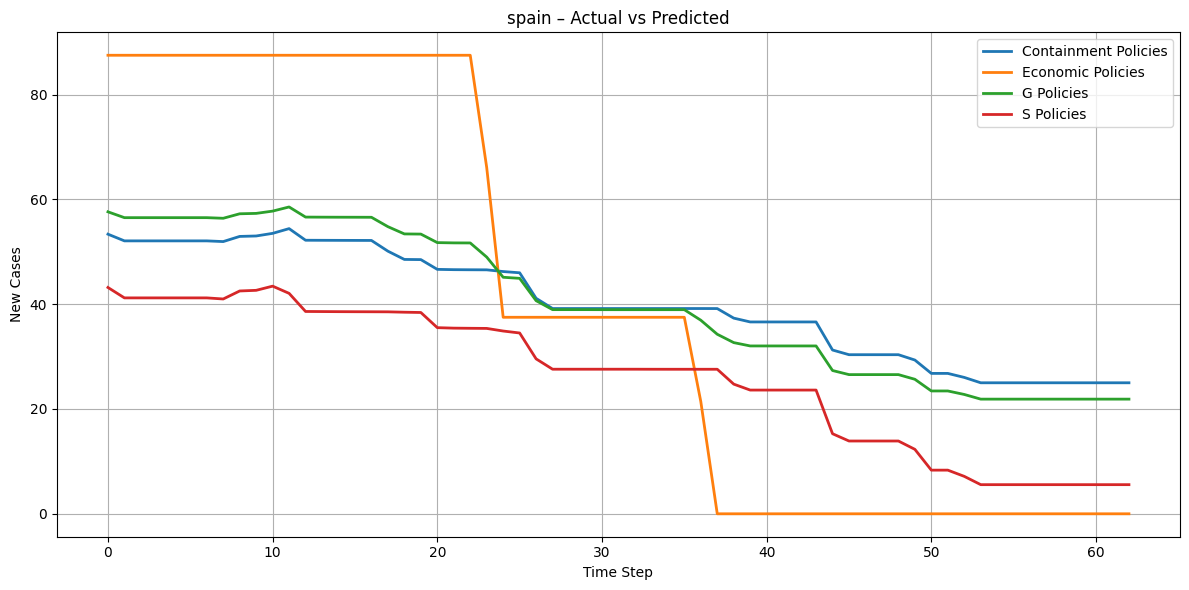

In [ ]:
# Plot actual vs predicted
df_target = df.loc[df.location == target_country].copy().reset_index(drop=True)
plt.figure(figsize=(12, 6))


plt.plot(df_target['C'], label='Containment Policies', linewidth=2)
plt.plot(df_target['E'], label='Economic Policies', linewidth=2)
plt.plot(df_target['G'], label='G Policies', linewidth=2)
plt.plot(df_target['S'], label='S Policies', linewidth=2)
plt.title(f"{test_country} – Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/prediction_plot_{test_country}.png")
plt.show()

aaaaaaaaaaaaaaaaaaaaaaaaaaa

In [ ]:
test_data
test_data.loc[10:, ['C', 'E', 'G', 'S', 'daily_vaccinations_per_million']] = 0